# fastai, chapter 4

This is a blog post to synthesize some knowledge from Chapter 4 of the [fastai course](https://course.fast.ai/).

In this chapter, we discussed the fundamentals of a simple neural net and built one from scratch. Our test case was the classic MNIST dataset, focusing on only two numbers specifically (3 and 7).

In this notebook, I'll reproduce the steps myself for training a fully-connected network on the MNIST dataset. The model will consider all 10 digits, and will focus on a pure PyTorch implementation. I'll also do the Q&A for the chapter.

In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [183]:
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")
print(device)

cpu


In [218]:
# A few constants
PIXELS_X, PIXELS_Y = 28, 28
PIXELS = PIXELS_X * PIXELS_Y
BATCH_SIZE = 128
EPOCHS = 5000
LEARNING_RATE = 0.00005
CLASSES = 10

In [ ]:
# Fetch the data (training and validation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

torch.Size([1, 1, 28, 28])


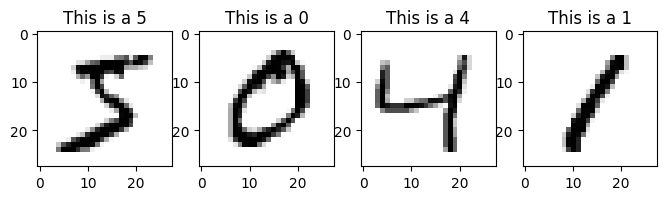

In [58]:
# Make a dataloader from the datasets just for visualization
viz_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
fig, ax = plt.subplots(ncols=4, figsize=(8, 2))
for i, (image, label) in enumerate(viz_loader):
    ax[i].imshow(image.reshape([28, 28]), cmap="gray_r")
    ax[i].set_title(f"This is a {label.item()}")
    if i >= 3:
        break
    if i == 0:
        print(image.shape)

In [174]:
# Make dataloaders from the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [211]:
# Make our model
model = nn.Sequential(
    nn.Linear(PIXELS, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [212]:
# Evaluate validation loss
def overall_loss(
    model: torch.nn.Sequential,
    loader: torch.utils.data.DataLoader,
):
    with torch.no_grad():
        num, loss, correct = 0.0, 0.0, 0.0
        for (x, y) in loader:
            # x = x.to(device)
            # y = y.to(device)
            batch, _, _, _ = x.shape
            preds = model(x.reshape([batch, PIXELS]))
            num += batch
            loss += F.cross_entropy(preds, y, reduction="sum")
            correct += (preds.argmax(axis=1) == y).sum()
        return loss / num, correct / num

In [216]:
loss = 999
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE/10)
for epoch in range(EPOCHS):

    announcement = any([
        epoch < 1e1,
        epoch < 1e2 and epoch % 1e1 == 0,
        epoch < 1e3 and epoch % 1e2 == 0,
        epoch < 1e4 and epoch % 1e3 == 0,
        epoch == EPOCHS - 1,
    ])
    
    if announcement:
        print(f"On epoch {epoch}", end=" ")

    for (x, y) in train_loader:
        # x = x.to(device)
        # y = y.to(device)
        optimizer.zero_grad()
        batch, _, _, _ = x.shape
        preds = model(x.reshape([batch, PIXELS]))
        loss = F.cross_entropy(preds, y)
        loss.backward()
        optimizer.step()

    if announcement:
        train_loss, train_acc = overall_loss(model, train_loader)
        valid_loss, valid_acc = overall_loss(model, valid_loader)
        print(f"loss (train) = {train_loss:.5f}, acc (train) = {train_acc:.5f}", end=" ")
        print(f"loss (valid) = {valid_loss:.5f}, acc (valid) = {valid_acc:.5f}")

On epoch 0 loss (train) = 0.17464, acc (train) = 0.95125 loss (valid) = 0.17944, acc (valid) = 0.94820
On epoch 1 loss (train) = 0.17464, acc (train) = 0.95125 loss (valid) = 0.17944, acc (valid) = 0.94820
On epoch 2 loss (train) = 0.17463, acc (train) = 0.95125 loss (valid) = 0.17944, acc (valid) = 0.94820
On epoch 3 loss (train) = 0.17463, acc (train) = 0.95125 loss (valid) = 0.17944, acc (valid) = 0.94820
On epoch 4 loss (train) = 0.17463, acc (train) = 0.95125 loss (valid) = 0.17944, acc (valid) = 0.94820
On epoch 5 loss (train) = 0.17463, acc (train) = 0.95125 loss (valid) = 0.17944, acc (valid) = 0.94820
On epoch 6 loss (train) = 0.17463, acc (train) = 0.95125 loss (valid) = 0.17943, acc (valid) = 0.94820
On epoch 7 loss (train) = 0.17462, acc (train) = 0.95125 loss (valid) = 0.17943, acc (valid) = 0.94830
On epoch 8 loss (train) = 0.17462, acc (train) = 0.95125 loss (valid) = 0.17943, acc (valid) = 0.94830
On epoch 9 loss (train) = 0.17462, acc (train) = 0.95127 loss (valid) = 0

Found a bad one
Found a bad one
Found a bad one
Found a bad one
Found a bad one
Found a bad one
Found a bad one
Found a bad one
Found a bad one
Found a bad one


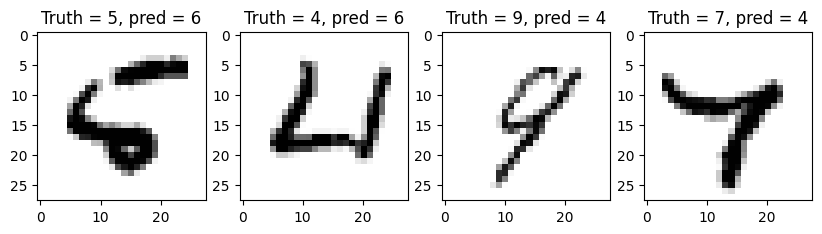

In [217]:
def find_worst(
    model: torch.nn.Sequential,
    loader: torch.utils.data.DataLoader,
):
    num_worst = 10
    i_incorrect = 0
    worst_images = torch.zeros([num_worst, 1, PIXELS_X, PIXELS_Y])
    worst_labels = torch.zeros([num_worst])
    worst_preds = torch.zeros([num_worst])
    with torch.no_grad():
        num, loss, correct = 0.0, 0.0, 0.0
        for (x, y) in loader:
            batch, _, _, _ = x.shape
            preds = model(x.reshape([batch, PIXELS]))
            correct = preds.argmax(axis=1) == y
            for i_data in range(len(correct)):
                if correct[i_data]:
                    continue
                print("Found a bad one")
                worst_images[i_incorrect] = x[i_data]
                worst_labels[i_incorrect] = y[i_data]
                worst_preds[i_incorrect] = preds[i_data].argmax()
                i_incorrect += 1
                
                if i_incorrect >= num_worst:
                    return worst_images, worst_labels, worst_preds

    return worst_images, worst_labels, worst_preds


worst_images, worst_labels, worst_preds = find_worst(model, valid_loader)
ncols = 4
fig, ax = plt.subplots(ncols=ncols, figsize=(10, 3))
for i in range(len(worst_labels)):
    if i >= ncols:
        break
    ax[i].imshow(worst_images[i].reshape(PIXELS_X, PIXELS_Y), cmap="gray_r")
    ax[i].set_title(f"Truth = {int(worst_labels[i])}, pred = {int(worst_preds[i])}")


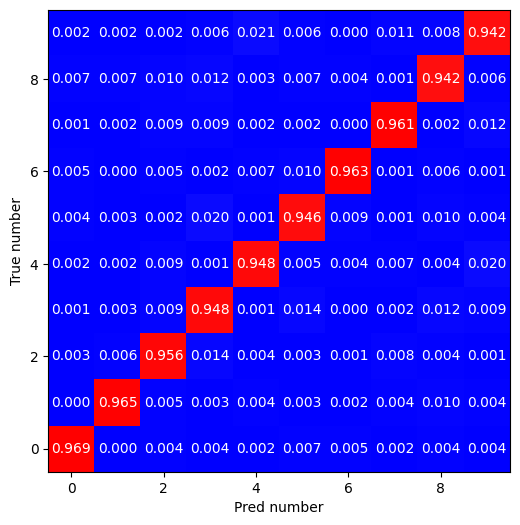

In [265]:
# Confusion matrix
def confusion_matrix(
    model: torch.nn.Sequential,
    loader: torch.utils.data.DataLoader,
):
    counts = np.zeros([CLASSES, CLASSES])
    with torch.no_grad():
        for (x, y) in loader:
            batch, _, _, _ = x.shape
            preds = model(x.reshape([batch, PIXELS]))
            for i_data in range(len(y)):
                counts[(
                    preds[i_data].argmax(),
                    y[i_data],
                )] += 1
    return counts


counts = confusion_matrix(model, train_loader)

# normalize rows (true number)
fracs = counts / counts.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(fracs, cmap="bwr", origin="lower")
ax.set_xlabel("Pred number")
ax.set_ylabel("True number")
for i in range(fracs.shape[0]):
    for j in range(fracs.shape[1]):
        ax.text(j, i, f"{fracs[i, j]:.3f}", ha='center', va='center', color='white')

## Questionnaire

Q: How is a grayscale image represented on a computer? How about a color image?

A: A grayscale image is represented as a matrix of pixel values, typically between 0 and 255 (8 bits). A color image is represented the same, except there is one matrix for each color: red, green, and blue (rgb).

Q: How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?

A: There are two layers of folders. The first layer is training and validation folders. The nested folders therein are numbers, i.e. 3 and 7. This is convenient because each folder contains the images of their specific purpose: `train/3/*.png`, `train/7/*.png`, `valid/3/*.png`, `valid/7/*.png`.

Q: Explain how the "pixel similarity" approach to classifying digits works.

A: We discussed "pixel similarity" as a way to predict whether an image was a 3 or a 7. The approach is to calculate an "ideal" 3 and ideal 7; measure the similarity of a test image with the ideal 3 and ideal 7; and choose the ideal number which is most similar to the test image. In our example, we had a test image of a 3 which was more similar to the ideal 3 than the ideal 7.

To calculate an ideal 3 (or 7), we measured an average pixel value of all 3s (or 7s) in our dataset.

To measure the similarity of a test image with an ideal number, we took the pixel-by-pixel difference between the test image and the ideal number. We considered the absolute difference (L1 norm) and squared difference (L2 norm) and both seemed to work okay.

Q: What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.

A: List comprehension is a pythonic way to create a list, from another list, in one line. For example,

```
odds_doubled = [2*num for num in range(20) if num % 2 == 1]
```

Q: What is a "rank-3 tensor"?

A: It's a 3-dimension tensor, e.g. a list of matrices.

Q: What is the difference between tensor rank and shape? How do you get the rank from the shape?

A: Tensor rank is how many dimensions exist. Tensor shape is how many dimensions exist and their sizes. For example, the shape of a MNIST image is [28, 28], whereas its rank is 2. The rank is the length of the shape.

Q: What are RMSE and L1 norm?

A: RMSE is the root-mean-squared-error, which is self-describing: given a list of errors (differences), we take the square of each number; find the mean; and take the square root. This is also called the L2 norm. The L1 norm is similar, except we take the absolute value instead of the square, and we don't bother with the square root.

Q: How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?

A: Whenever possible, do calculations within torch/numpy tensors/matrices, and not with a python loop.

Q: Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

A: `tensor = (torch.arange(1, 10).reshape(3, 3) * 2)[1:, 1:]`

Q: What is broadcasting?

A: Broadcasting is the way torch/numpy "fill in the blanks" in a variety of calculations. When performing operations on differently-sized matrices, broadcasting will essentially pad the smaller-dimension matrix with copies of itself to fit the larger-dimension matrix. It's magical.

Q: Are metrics generally calculated using the training set, or the validation set? Why?

A: Validation set. The training set always suffers from overfitting and would provide a biased measurement of the metric.

Q: What is SGD?

A: Stochastic gradient descent. It's gradient descent, but chunks of data at a time (calling it "stochastic" is generous).

Q: Why does SGD use mini-batches?

A: Large datasets make it prohibitive to use entire datasets for SGD. Using individual data points is slow and inefficient. Mini-batches is a compromise to keep the GPU working hard

Q: What are the seven steps in SGD for machine learning?

A: Initialize weights. Forward pass. Calculate loss. Backward pass. Step. Repeat. Stop.

Q: How do we initialize the weights in a model?

A: Randomly, with "small" values.

Q: What is "loss"?

A: It's a measure of how accurately our predictions match the targets. We want it to be a smooth, continuous function which is good for gradient descent.

Q: Why can't we always use a high learning rate?

A: SGD doesn't converge when the learning rate is high.

Q: What is a "gradient"?

A: A gradient is a derivative, or possibly a list of derivatives, depending on who you're talking to.

Q: Do you need to know how to calculate gradients yourself?

A: Typically no. PyTorch and other popular libraries can do it for me.

Q: Why can't we use accuracy as a loss function?

A: A binary function like accuracy (correct/incorrect) isn't nice for gradient descent, which means it isn't nice for a loss function. For example, if a model successfully predicts the number 3 with 80% confidence vs 90% confidence, the loss should reflect that the 90% prediction is better than the 80% prediction. But this information is lost when considering accuracy, which assigns "correct" to both predictions.

Q: Draw the sigmoid function. What is special about its shape?

A: It's like a S-shape. It's a convenient function for a classifier because it's outputs are between 0 and 1.

Q: What is the difference between a loss function and a metric?

A: A loss function is a metric! But a metric isn't always a loss function. Ideally, a loss function is a smooth, continuous function which is good for gradient descent. Metrics are usually more human-friendly.

Q: What is the function to calculate new weights using a learning rate?

A: `weights -= learning_rate * weights.grad`

Q: What does the `DataLoader` class do?

A: It's a PyTorch class which is a convenient interface to the raw data. It does batching and shuffling for us.

Q: Write pseudocode showing the basic steps taken in each epoch for SGD.

A: prediction = model(x). loss = loss_function(prediction, y). loss.backward(). model.parameters().data -= model.parameters.grad() * learning_rate.

Q: Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?

A: `list(enumerate("abcd"))`. I'm gonna ignore the request to start with index=1. This output data structure is similar to a PyTorch `Dataset` class.

Q: What does `view` do in PyTorch?

A: It provides a reshaped view of a tensor without changing the underlying data (i.e., it's computationally inexpensive).

Q: What are the "bias" parameters in a neural network? Why do we need them?

A: They're constants. In the `m * x + b` analogy, they are the `b`. They're a handy additional degree of freedom. I suppose they're not strictly necessary, but they're hurting anybody, why not have them?

Q: What does the `@` operator do in Python?

A: `@` does matrix multiplication.

Q: What does the `backward` method do?

A: This evaluate the gradients of all parameters linked to a tensor.

Q: Why do we have to zero the gradients?

A: Interally, PyTorch sums gradients from individual data samples within a batch (I think) to find an average gradient. This means the sum must be reset to zero between batches.

Q: What information do we have to pass to `Learner`?

A: Dataset, architecture, optimizer, loss function, and metrics.

Q: Show Python or pseudocode for the basic steps of a training loop.

A: 

```
for batch in data:
  make prediction
  calculate loss
  calculate gradients
  update prediction parameters
  zero gradients
```

Q: What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.

A: ReLU is rectified linear unit (lol). It's a function f(x) which is defined as zero when x is negative, and x with x is positive.

Q: What is an "activation function"?

A: It's a non-linear function which is applied element-wise at each layer of a network. ReLU is a common activation function.

Q: What's the difference between `F.relu` and `nn.ReLU`?

A: `F.relu` is a function-style implementation of relu, whereas `nn.ReLU` is a class-style implemetation. `nn.ReLU` is necessary when doing a `nn.Sequential` model, for example.

Q: The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

A: Using multiple layers of network, and therefore multiple non-linearities, provide more freedom to the network. This can often give better performance.


In [246]:
x = np.array([1, 2, 3])
x.astype(float)

array([1., 2., 3.])